In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

###### Import packages needed for the make_vars functions
from scipy.interpolate import interp1d

from skimage.filters.rank import entropy
from skimage.morphology import rectangle
from skimage.util import img_as_ubyte

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.head()

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915

In [2]:
def make_entropy_vars(wells_df,logs,l_foots):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])
    
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        
        for log in logs:
            temp_data = grouped.get_group(key)[log]
            image = np.vstack((temp_data,temp_data,temp_data))
            image -= np.median(image) 
            image /= np.max(np.abs(image))
            image = img_as_ubyte(image)
            
            for l_foot in l_foots:     
                footprint = rectangle(l_foot,3)
                temp_df[log + '_entropy_foot' + str(l_foot)] = entropy(image,footprint)[0,:]
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
    
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df,new_df],axis=1)

In [3]:
##### From entropy
entropy_df = make_entropy_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                               l_foots=[2, 3, 4, 5, 7, 10, 20])
print (entropy_df.shape)
entropy_df.head(5)

(4149, 39)


Facies Formation  Well Name   Depth  GR_entropy_foot2  GR_entropy_foot3  \
0       3     A1 SH  SHRIMPLIN  2793.0          1.000000          1.000000   
1       3     A1 SH  SHRIMPLIN  2793.5          0.918296          0.918296   
2       3     A1 SH  SHRIMPLIN  2794.0          0.918296          0.918296   
3       3     A1 SH  SHRIMPLIN  2794.5          1.584963          1.584963   
4       3     A1 SH  SHRIMPLIN  2795.0          0.918296          0.918296   

   GR_entropy_foot4  GR_entropy_foot5  GR_entropy_foot7  GR_entropy_foot10  \
0          1.000000          1.000000          1.000000           1.000000   
1          0.918296          0.918296          0.918296           0.918296   
2          0.918296          0.918296          0.918296           0.918296   
3          1.584963          1.584963          1.584963           1.584963   
4          0.918296          0.918296          0.918296           0.918296   

           ...           PE_entropy_foot7  PE_entropy_foot10  \
0          ...                   1.000000           1.000000   
1          ...                   1.584963           1.584963   
2          ...                   0.918296           0.918296   
3          ...                   0.000000           0.000000   
4          ...                   0.000000           0.000000   

   PE_entropy_foot20  PHIND_entropy_foot2  PHIND_entropy_foot3  \
0           1.000000             1.000000             1.000000   
1           1.584963             1.584963             1.584963   
2           0.918296             1.584963             1.584963   
3           0.000000             1.584963             1.584963   
4           0.000000             1.584963             1.584963   

   PHIND_entropy_foot4  PHIND_entropy_foot5  PHIND_entropy_foot7  \
0             1.000000             1.000000             1.000000   
1             1.584963             1.584963             1.584963   
2             1.584963             1.584963             1.584963   
3             1.584963             1.584963             1.584963   
4             1.584963             1.584963             1.584963   

   PHIND_entropy_foot10  PHIND_entropy_foot20  
0              1.000000              1.000000  
1              1.584963              1.584963  
2              1.584963              1.584963  
3              1.584963              1.584963  
4              1.584963              1.584963  

[5 rows x 39 columns]

In [4]:
####### Creating dictionary of colours for the different facies
facies_colors = {1:'#F4D03F', 2:'#F5B041',3:'#DC7633',4:'#6E2C00',
       5:'#1B4F72',6:'#2E86C1', 7:'#AED6F1', 8:'#A569BD', 9:'#196F3D'}
facies_name = {1:'SS', 2:'CSiS',3:'FSiS',4:'SiSh', 5:'MS',6:'WS', 7:'D', 8:'PS', 9:'BS'}

flatui = ['#F4D03F', '#F5B041', '#DC7633', '#6E2C00',
       '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

In [5]:
sns.set()
temp_df = entropy_df
temp_df = temp_df.drop(['Formation', 'Well Name', 'Depth'], axis=1)
temp_df.dropna(inplace=True)
sns.pairplot(temp_df, hue='Facies', palette = flatui)

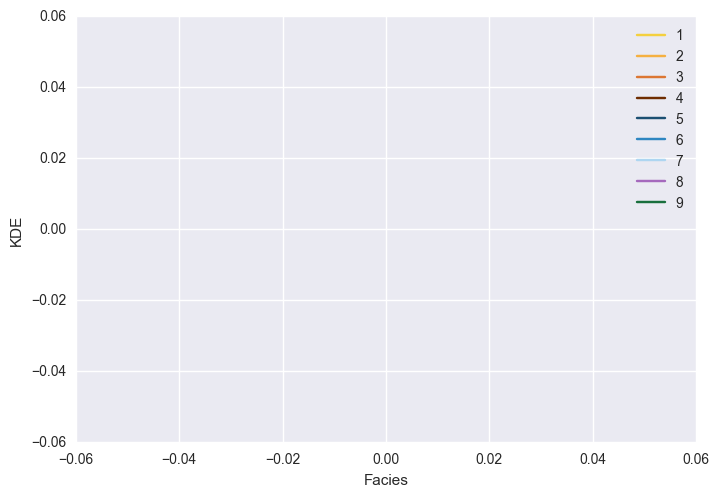

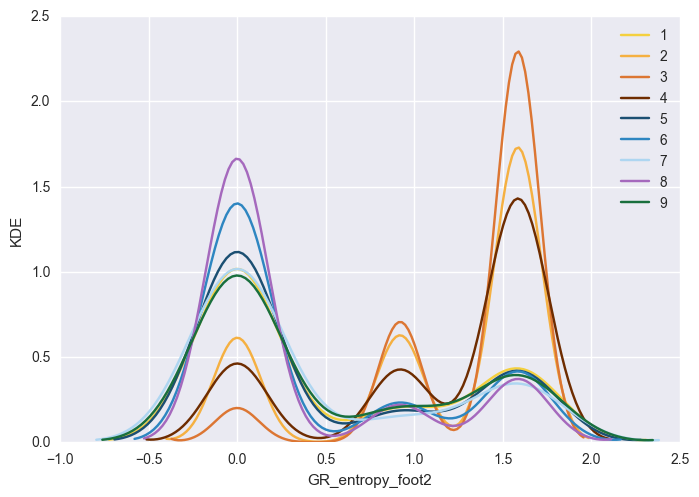

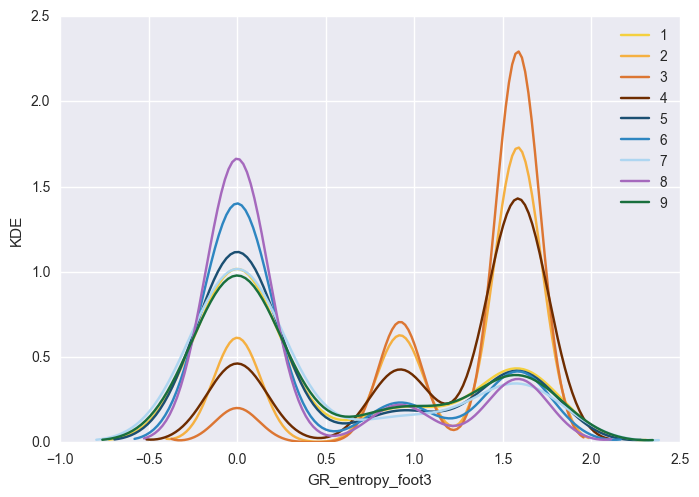

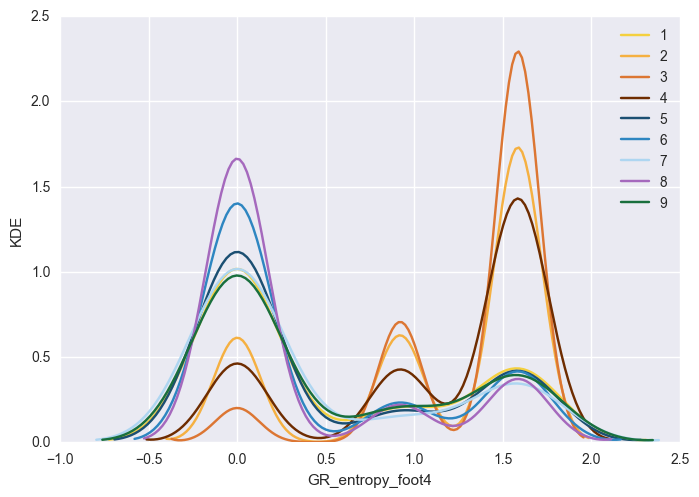

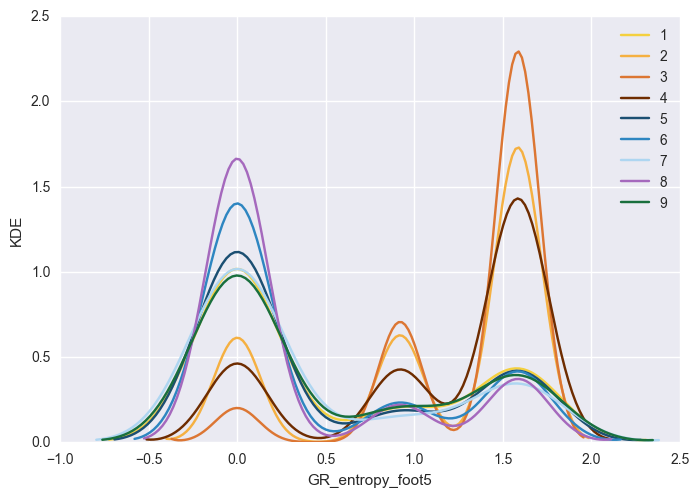

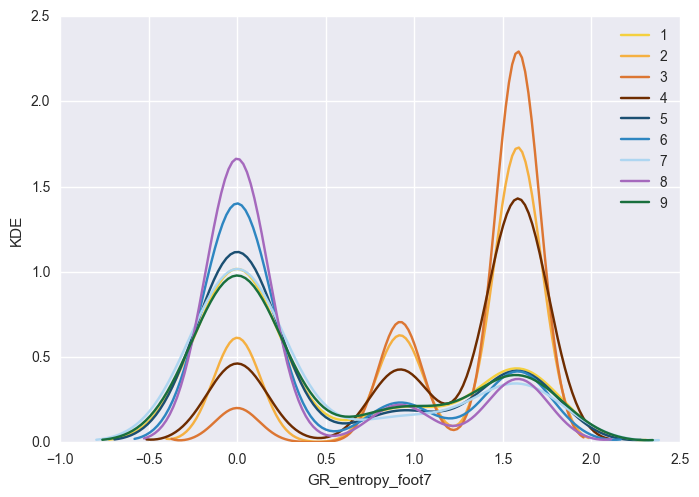

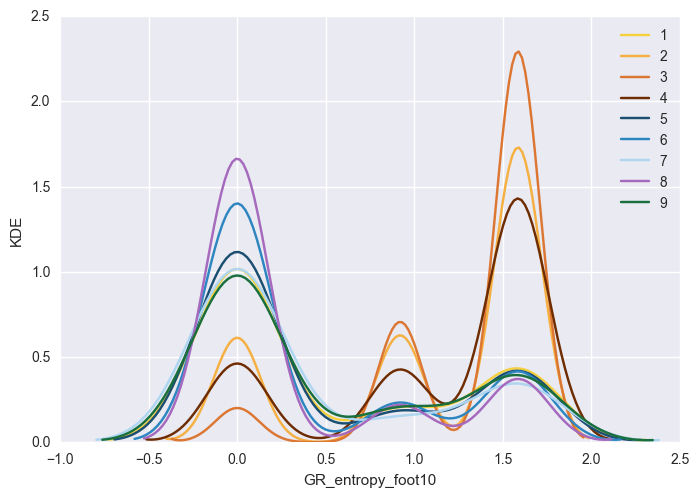

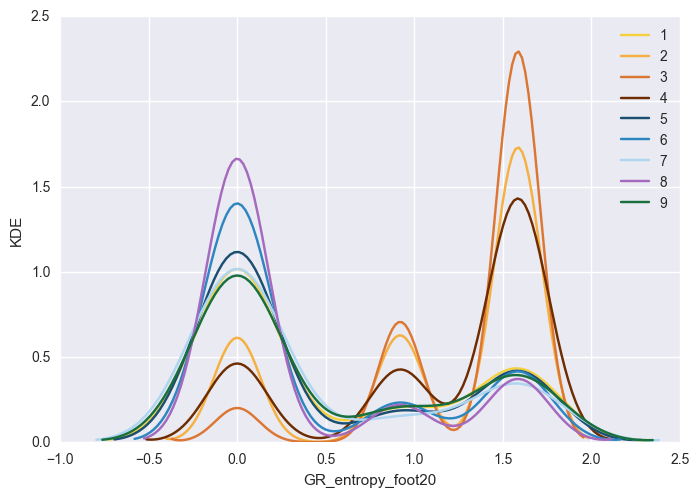

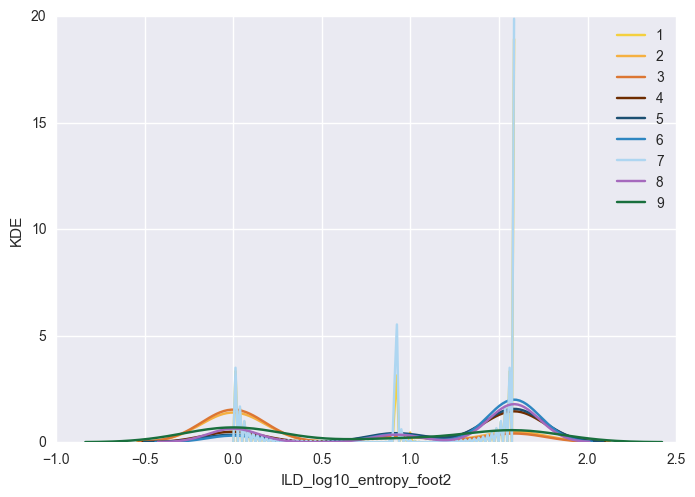

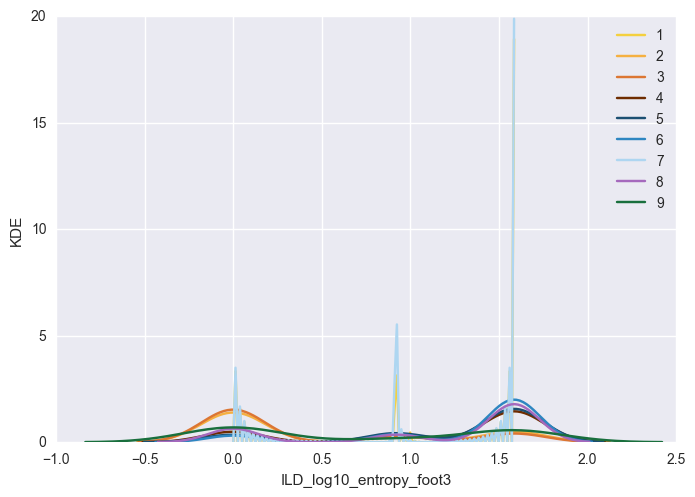

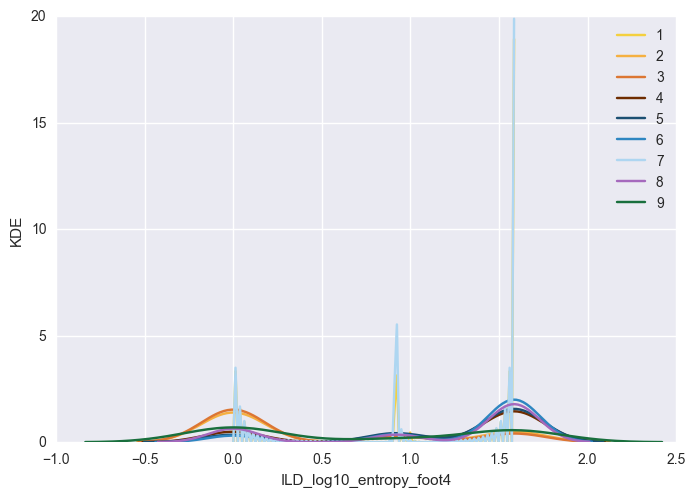

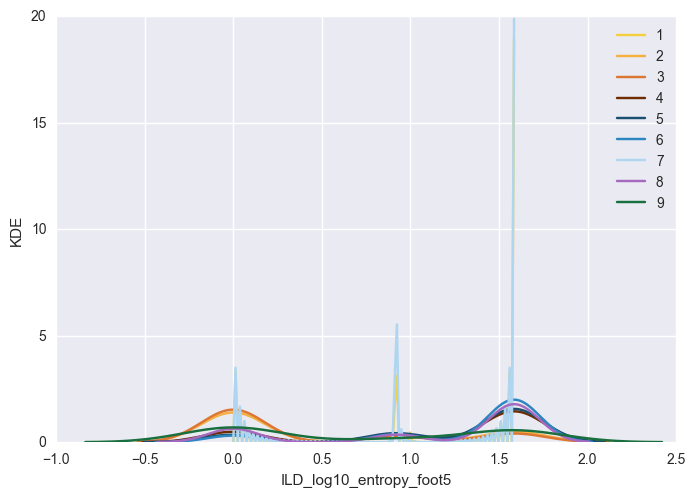

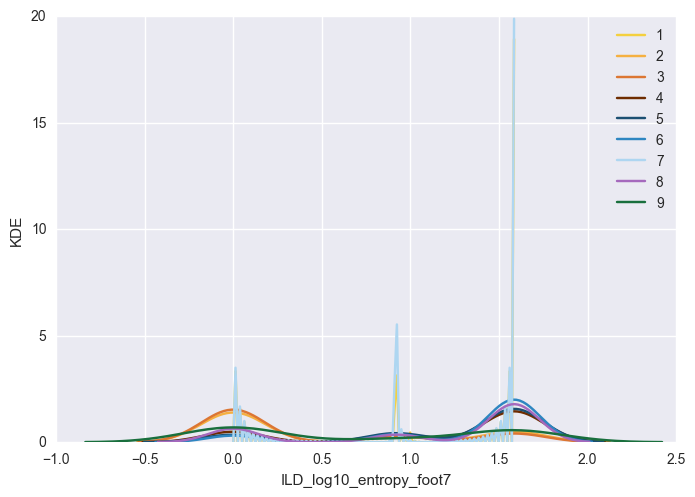

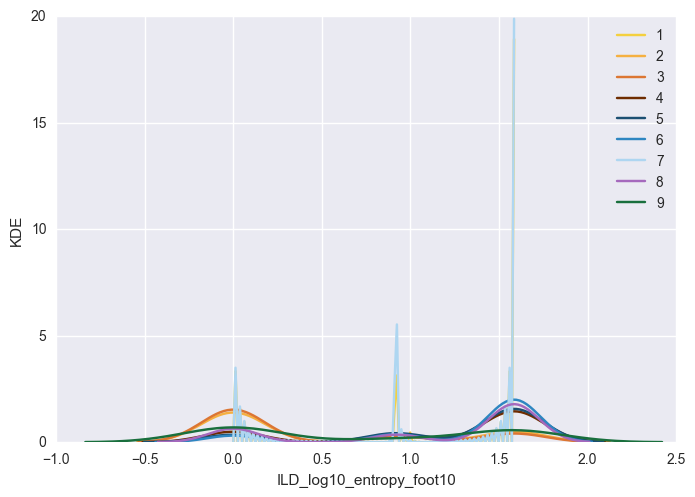

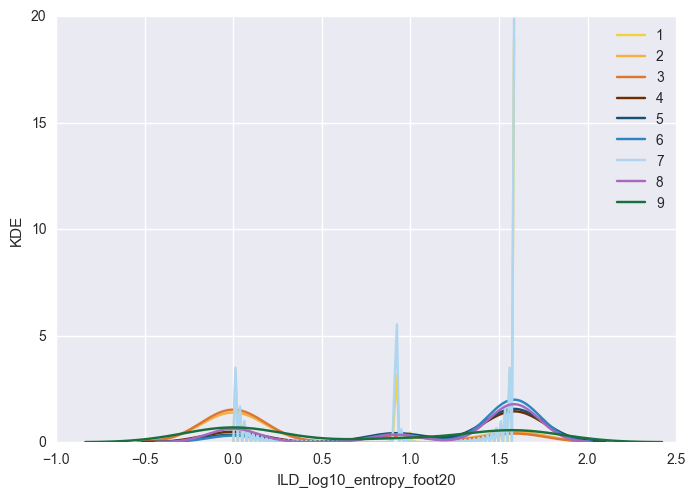

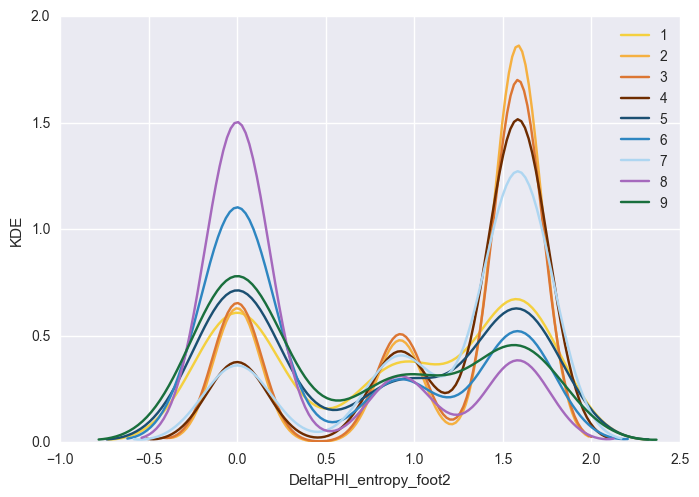

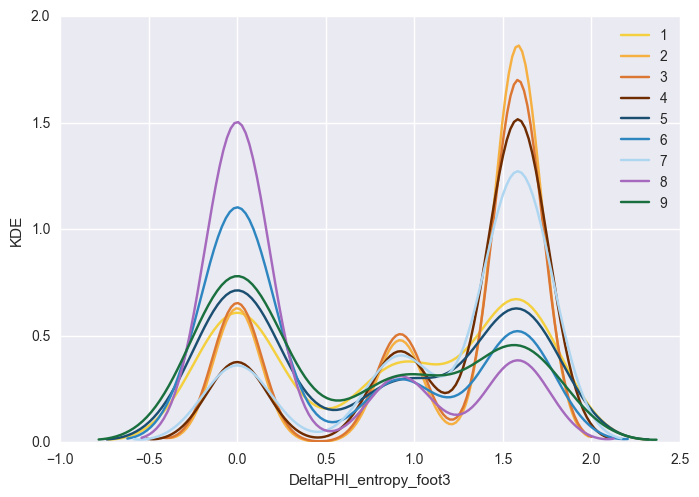

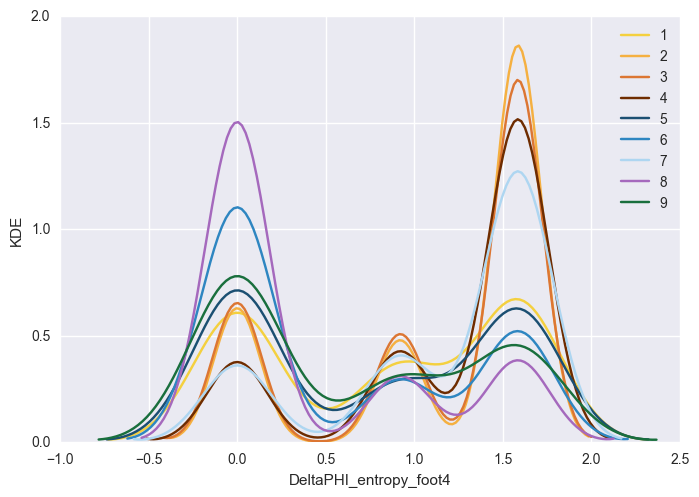

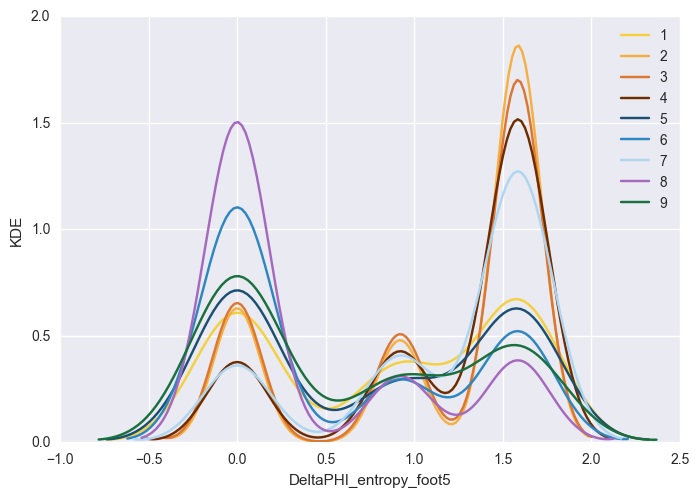

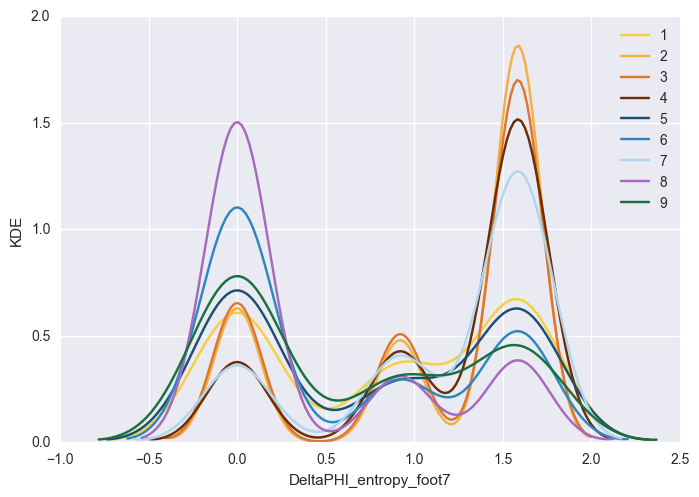

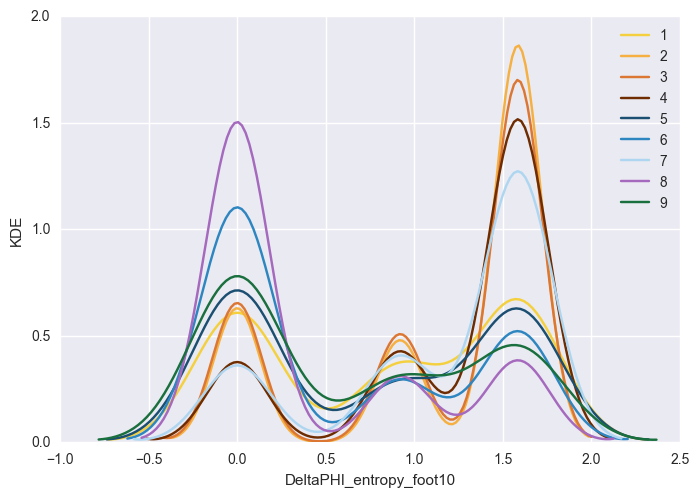

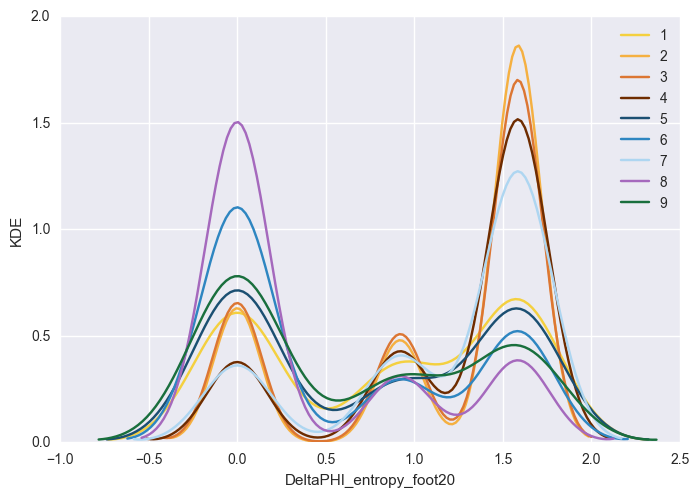

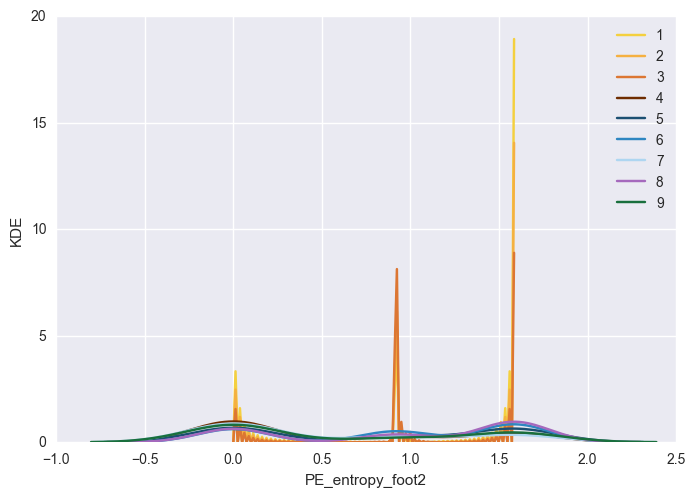

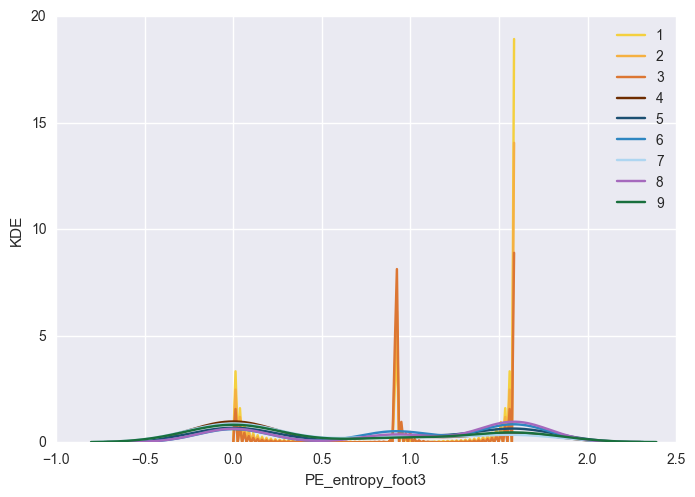

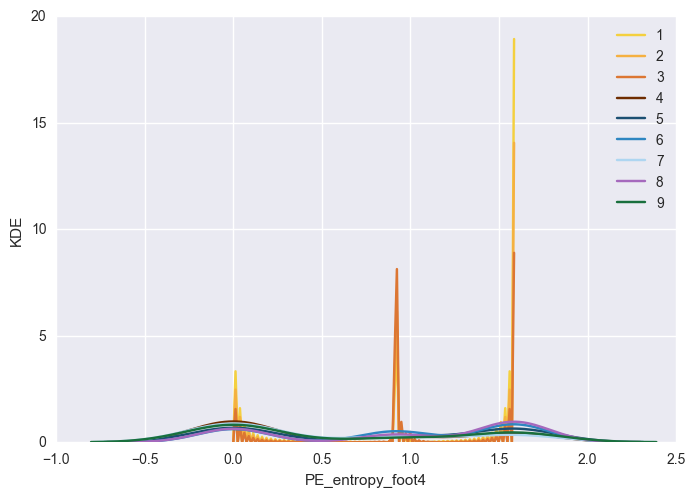

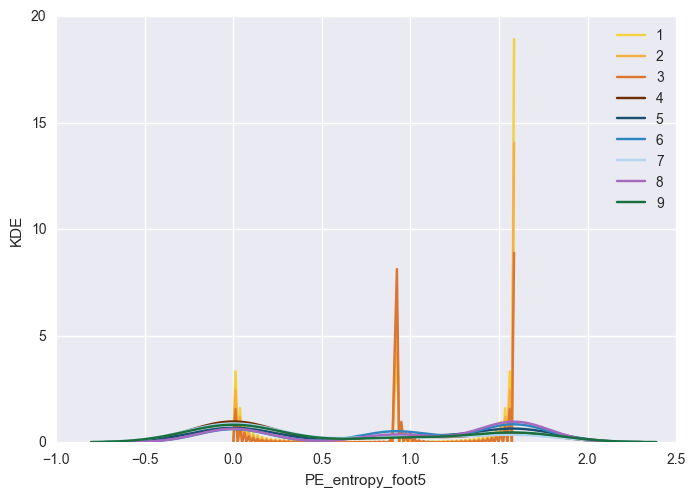

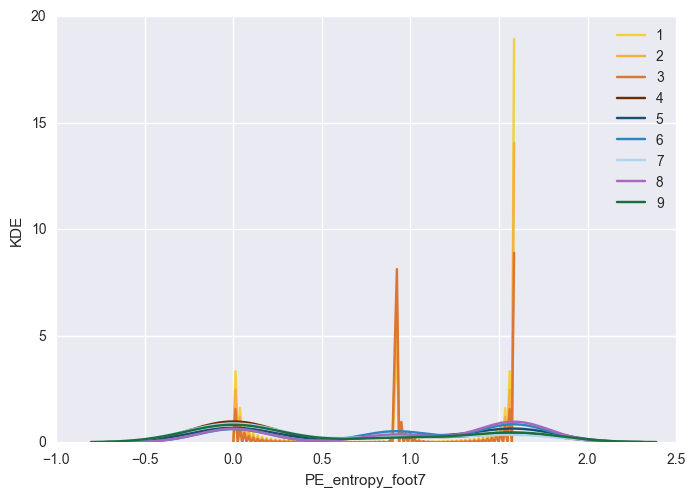

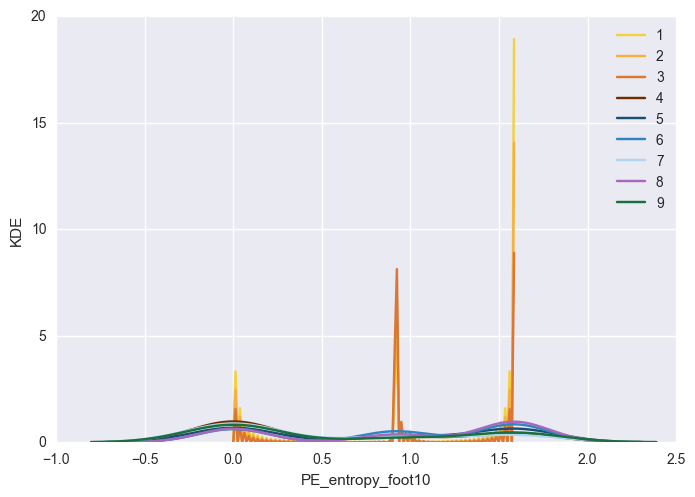

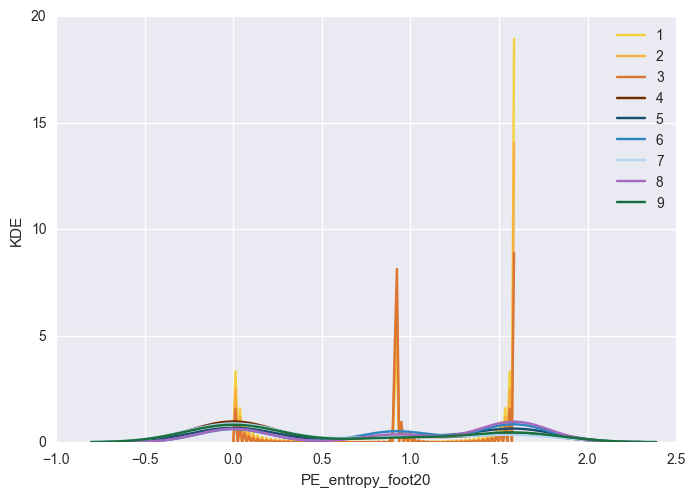

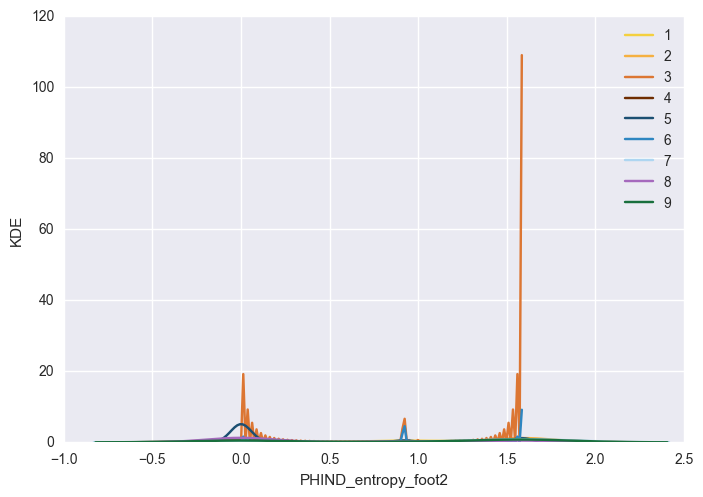

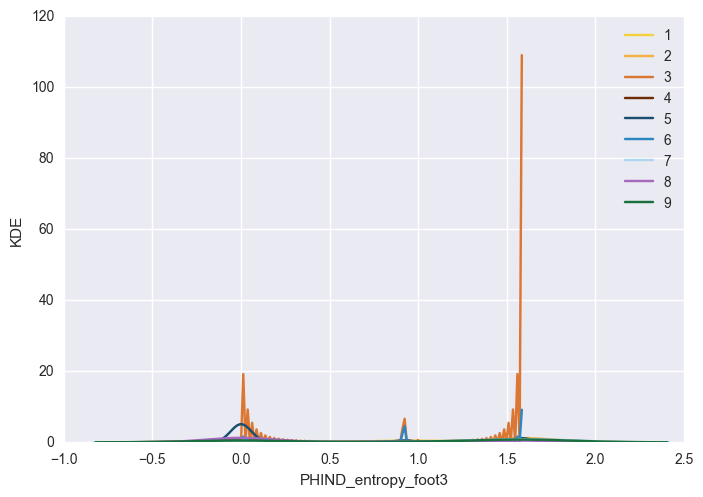

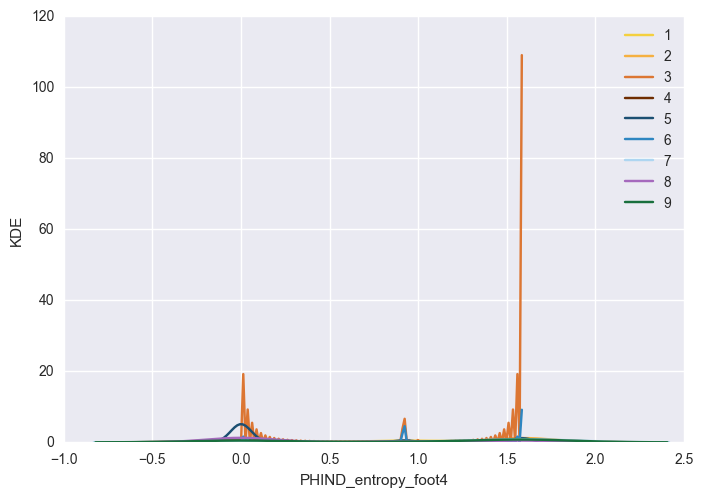

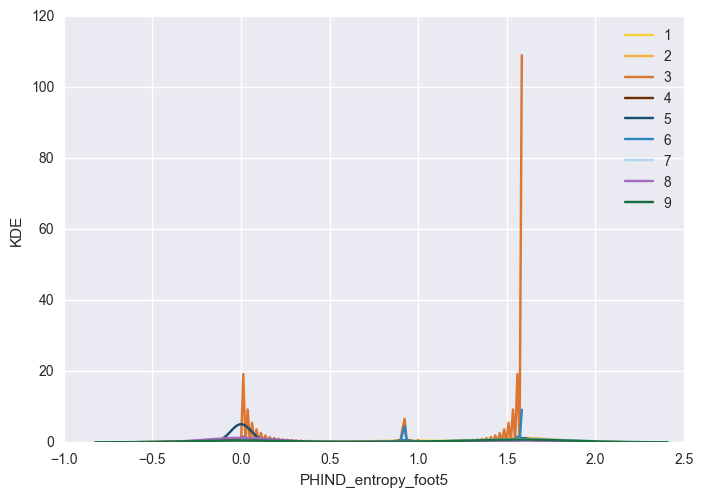

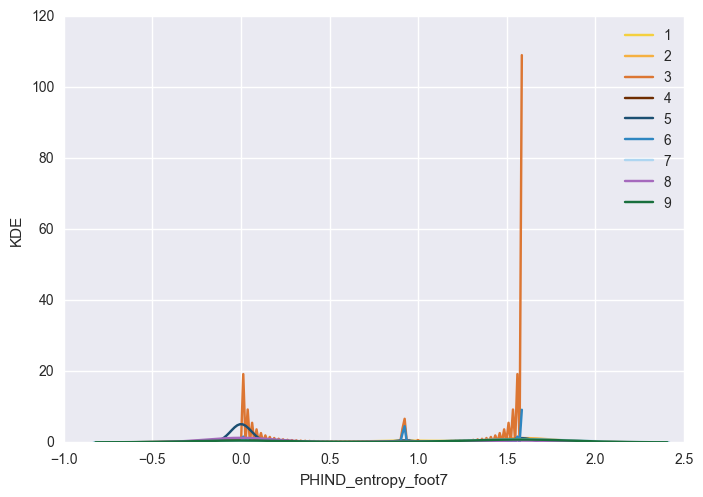

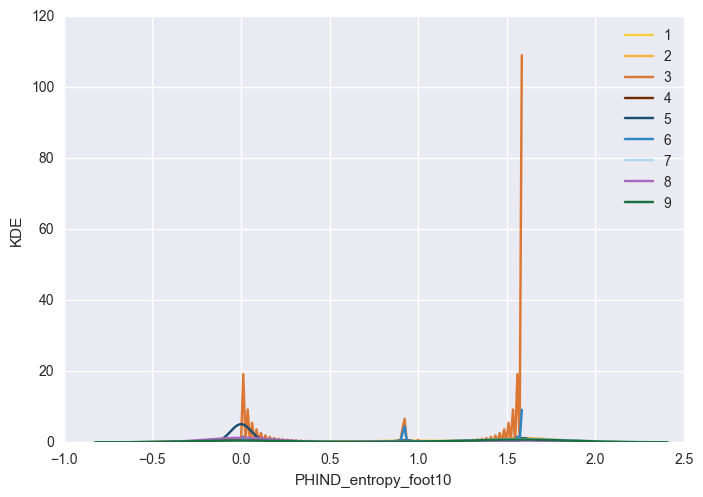

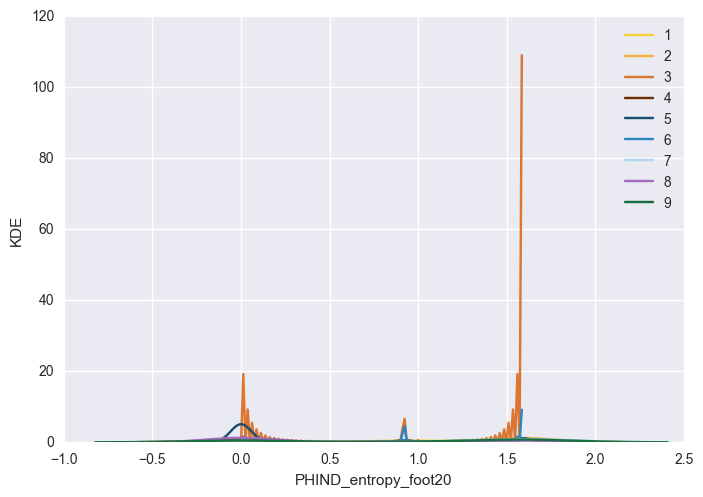

In [6]:
sns.set_palette(flatui)
list_variables = list(entropy_df.columns.values)
list_variables.remove('Formation')
list_variables.remove('Well Name')
list_variables.remove('Depth')
#list_variables = ['GR_cD_step_level_1', 'GR_cA_step_level_1', 'GR_cD_step_level_2', 'GR_cA_step_level_2', 'GR_cD_step_level_3', 'GR_cA_step_level_3']
for a in list_variables:
    for i in np.arange(1, 10, 1):
        sns.kdeplot(entropy_df[a][entropy_df['Facies'] == i], label=i)
    plt.xlabel(a)
    plt.ylabel('KDE')
    plt.show()